<a href="https://colab.research.google.com/github/lnetw/MTS_ML/blob/main/ML_%D0%A1%D1%82%D0%B5%D0%BD%D0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title # **Стенд демонстрация ML решения в рамках 3 домашнего задания** 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
sns.set(font_scale = 1.5)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import xgboost
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

df = pd.read_csv('Credit Risk Analysis for extending Bank Loans.csv')
df = df.dropna(axis = 0)
x_train, x_test, y_train, y_test = train_test_split(df.drop(['default'], axis = 1), df['default'], test_size= 0.2, stratify = df['default'], random_state=82)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

for df in x_train, x_test:
    df['alldebt'] = df['creddebt']+df['othdebt']
    df['balance'] = df['income']-df['debtinc']
cat_cols = ['ed']

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(x_train[cat_cols])

x_train_ohe = pd.DataFrame(enc.transform(x_train[cat_cols]), columns= enc.get_feature_names(cat_cols)) 
x_test_ohe = pd.DataFrame(enc.transform(x_test[cat_cols]), columns= enc.get_feature_names(cat_cols))

x_train = pd.concat([x_train.reset_index(drop=True), x_train_ohe],sort = False, axis=1).drop(['ed'], axis=1)
x_test = pd.concat([x_test.reset_index(drop=True), x_test_ohe],sort = False, axis=1).drop(['ed'], axis=1)

oversample = SMOTE(random_state=9)
x_train, y_train = oversample.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_train, columns=x_test.columns)

logistic = LogisticRegressionCV(cv = 5, random_state=15)
logistic.fit(x_train, y_train)

model =  XGBClassifier(random_state=5)
model.fit(x_train, y_train)

y_predict_log = model.predict(x_test)

y_predict_mod = logistic.predict(x_test)


def plot_heat_map(y_test, y_predict):
  cm = confusion_matrix(y_test, y_predict)

  conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
  plt.figure(figsize = (5,5))
  fig = sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False)
  return conf_matrix, fig


def plot_roc_curve(prob_prediction, actual):
    
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

В рамках решения 3 домашней работы, была поставлена задача разработать демо стенд в котором будут отображены основные результаты работы, алгоритма. Сперва посмотрим на пропорцию в плане отданных и невозвратных кредитов.

In [159]:
#@title Соотношение классов целевой перменной нашей задачи


credit_df = pd.DataFrame(df['default'].value_counts())
fig = px.pie(credit_df, values='default', names=['Возвращенные кредиты', 'Невозвратные кредиты'])
fig.show()

Здесь явно виде дисбаланс классов, что было учтено при разработке алгоритма. Были получены 2 модели, первая базовая модель с использование алгоритма логистической регрессии, и вторая более продвинутая, основанная на градиентном бустинге. Результаты работы этих моделей в виде матриц ошибок представлены ниже. 

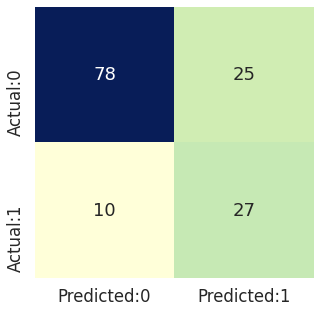

In [77]:
#@title Матрица ошибок классификации базового алогритма

log_conf, log_fig = plot_heat_map(y_test, y_predict_log)

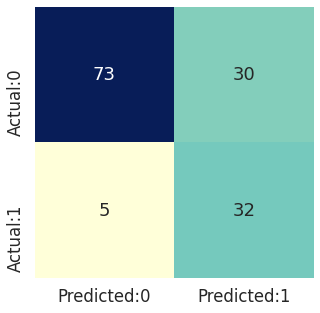

In [83]:
#@title Матрица ошибок классификации разработанного алгоритма

mod_conf, mod_fig = plot_heat_map(y_test, y_predict_mod)

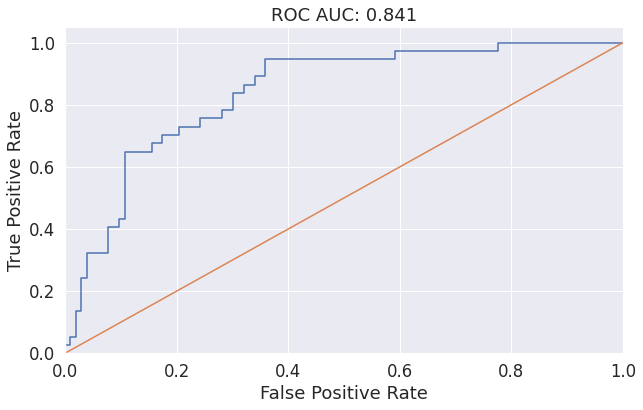

In [74]:
#@title ROC AUC кривая разработанного алогритма

plot_roc_curve(model.predict_proba(x_test)[:,1], y_test)

Как видно по данным метрикам качества, что разработанная модель имеет гораздо лучшие показатели качества. По матрицам ошибок видно, что хоть мы с новой моделью и выдаем меньше кредитов, но получаем больше верных ответов в классе невозврата кредитов, что существенно повышает ценность нашего алгоритма. Посмотрим на эти показатели в сравнении.






In [125]:
#@title Сравнения распознанных невозвратных кредитов по видам моделей

pie_df = pd.DataFrame({'Baseline_model':log_conf['Predicted:1']['Actual:1'],'XGB_model':mod_conf['Predicted:1']['Actual:1']}, index=['Невозвращенные кредиты'])
fig = px.pie(pie_df.transpose(), values='Невозвращенные кредиты', names=['Базовая модель', 'XGB модель'])
fig.show()

Ну и теперь перейдем к еще одной важной части нашей задачи, а именно отбор признаков, которые влияют в самом большом смысле на целевую переменную. Здесь можно выделить топ 5 признаков которые влияют на выдачу кредита. А именно: 'Сумма долга', 'Работа', 'Жилье', 'Кредитная история' и 'Возраст'.

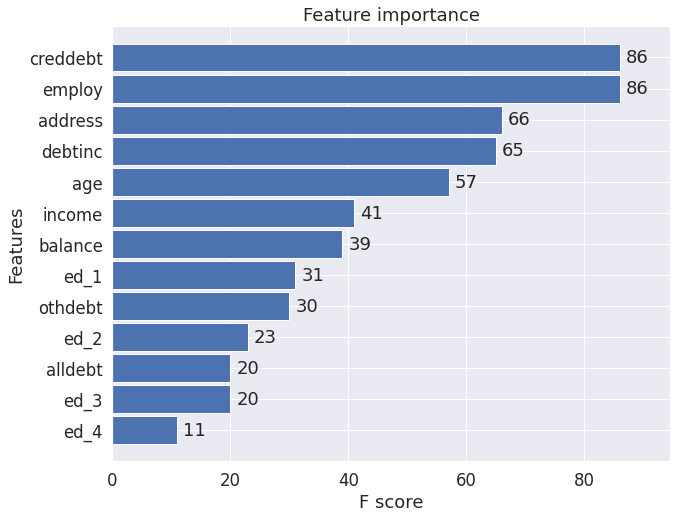

In [127]:
#@title Важность признаков при классификации кредитов

fig, ax = plt.subplots(1,1,figsize=(10,8))
xgboost.plot_importance(model, height=0.9, ax=ax)